In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [0]:
# %ls ./data/processed
# # T12H-X850M-Y880M_2013-01-01_2015-01-01/
# # T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
# # T1H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X255M-Y220M_2013-01-01_2015-01-01/
# # T24H-X425M-Y440M_2013-01-01_2015-01-01/
# # T24H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X85M-Y110M_2013-01-01_2015-01-01/
# # T3H-X850M-Y880M_2013-01-01_2015-01-01/
# # T6H-X850M-Y880M_2013-01-01_2015-01-01/

T12H-X850M-Y880M_2013-01-01_2015-01-01/
T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
T1H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X255M-Y220M_2013-01-01_2015-01-01/
T24H-X425M-Y440M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X85M-Y110M_2013-01-01_2015-01-01/
T3H-X850M-Y880M_2013-01-01_2015-01-01/
T6H-X850M-Y880M_2013-01-01_2015-01-01/


In [8]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf

from utils.utils import write_json, Timer
from models.st_resnet_models import STResNet, STResNetExtra
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_fnn_data_classification
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models

In [9]:
USE_EXTRA = False # todo move extra model to own notebook

start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M" #"T1H-X1700M-Y1760M" # "T24H-X850M-Y880M" # needs to exist
conf = BaseConf()

if USE_EXTRA:
    conf.model_name = "ST-RESNET-Extra"  # needs to be created
else:     
    conf.model_name = "ST-RESNET"  # needs to be created

conf.data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-11-06T13:36:56 | root | INFO | =====================================BEGIN=====================================
2019-11-06T13:36:56 | root | INFO | Device: cpu


### Training loop

In [10]:
def train_epoch_for_st_res_net_extra(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the STResNetExtra model for a single epoch
    """
    epoch_losses = []
    num_batches = batch_loader.num_batches
    
    demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
    street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)

    for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
        current_batch = batch_loader.current_batch

        batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
        batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
        batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
        batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
        batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

        batch_pred = model(seq_c=batch_seq_c,
                           seq_p=batch_seq_p,
                           seq_q=batch_seq_q,
                           seq_e=batch_seq_e,
                           seq_demog=demog_grid,
                           seq_gsv=street_grid)
        
        # might need to flatten
        loss = loss_fn(input=batch_pred, target=batch_seq_t)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])
        
        if model.training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    
    return mean_epoch_loss


def train_epoch_for_st_res_net(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the STResNet model for a single epoch
    """
    epoch_losses = []
    num_batches = batch_loader.num_batches
    
    for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
        current_batch = batch_loader.current_batch

        batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
        batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
        batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
        batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
        batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

        batch_pred = model(seq_c=batch_seq_c,
                           seq_p=batch_seq_p,
                           seq_q=batch_seq_q,
                           seq_e=batch_seq_e)
        
        # might need to flatten
        loss = loss_fn(input=batch_pred, target=batch_seq_t)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])
        
        if model.training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")

    mean_epoch_loss = np.mean(epoch_losses)
    
    return mean_epoch_loss

In [11]:
log.info(f"\n ====================== Config Values ====================== \n{conf}" +
         "\n ====================== Config Values ====================== \n")

2019-11-06T13:36:59 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'lr': 0.001,
 'max_epochs': 1,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': False,
 'sub_sample_train_set': True,
 'sub_sample_validation_set': True,
 'timer': <utils.utils.Timer object at 0x1a2a4afe80>,
 'tolerance': 1e-08,
 'tst_ratio': 0.3,
 'use_crime_types': False,
 'use_cuda': False,
 'use_seq_loss': True,
 'val_ratio': 0.1,
 'weight_decay': 1e-08}
 ===================

In [12]:
# SET THE HYPER PARAMETERS
conf.dropout = 0#0.2
conf.weight_decay = 0
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-2
conf.batch_size = 256

# MOCK = False

# CRIME DATA
data_group = GridDataGroup(data_path=conf.data_path,
                           conf=conf)

loaders = GridDataLoaders(data_group=data_group,
                          conf=conf)

2019-11-06T13:37:01 | root | INFO | 	t_range shape (731,)


2019-11-06T13:37:01 | root | INFO | Start Training ST-RESNET
2019-11-06T13:37:01 | root | INFO | Using optimiser: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


2019-11-06T13:37:01 | root | INFO | Epoch: 0001/0006
2019-11-06T13:37:04 | root | INFO | 	Loss (Trn): 	0.12775
2019-11-06T13:37:04 | root | INFO | 	Loss (Val): 	0.01310
2019-11-06T13:37:04 | root | INFO | 	Loss (Dif): 	0.11465

2019-11-06T13:37:04 | root | INFO | Epoch: 0002/0006
2019-11-06T13:37:06 | root | INFO | 	Loss (Trn): 	0.01427
2019-11-06T13:37:06 | root | INFO | 	Loss (Val): 	0.01475
2019-11-06T13:37:06 | root | INFO | 	Loss (Dif): 	0.00048

2019-11-06T13:37:06 | root | INFO | Epoch: 0003/0006
2019-11-06T13:37:09 | root | INFO | 	Loss (Trn): 	0.01554
2019-11-06T13:37:09 | root | INFO | 	Loss (Val): 	0.01495
2019-11-06T13:37:09 | root | INFO | 	Loss (Dif): 	0.00059

2019-11-06T13:37:09 | root | INFO | Epoch: 0004/0006
2019-11-06T13:37:12 | root |

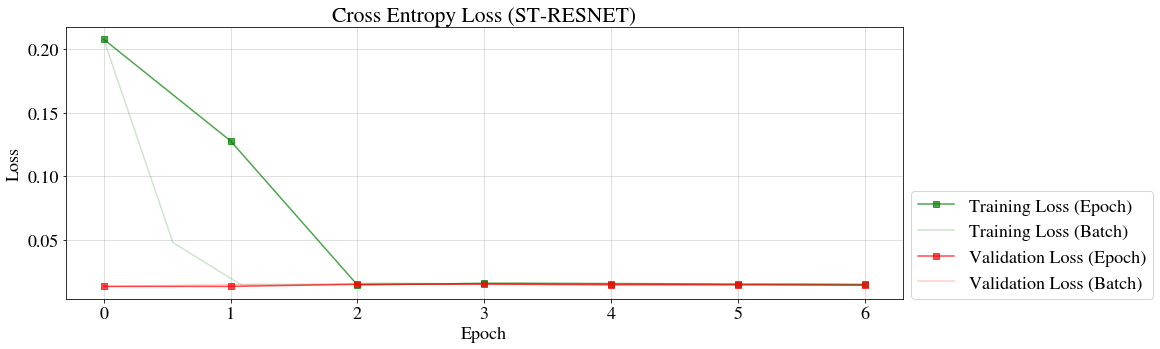

In [13]:
conf.resume = False
conf.freqstr = data_group.t_range.freqstr  
conf.early_stopping = False
conf.max_epochs = 6

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()  

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape

conf.n_layers = 3  # number of res-unit layers
conf.n_channels = 1 # inner channel size of the res-units 

if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net_extra
    model = STResNetExtra(n_layers=conf.n_layers,
                          n_channels=conf.n_channels,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    model = STResNet(n_layers=conf.n_layers,
                     n_channels=conf.n_channels,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)    
    
# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

#         # new optimiser hyper-parameters
#         optimiser.param_groups[0]['lr'] = conf.lr
#         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                           optimiser=optimiser,
                                           loaders=loaders,
                                           train_epoch_fn=train_epoch_fn,
                                           loss_fn=loss_function,
                                           conf=conf)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

### Evaluation Code

In [39]:
from utils.metrics import best_threshold

In [40]:
# FIX NORMAL ONE FIRST THEN ADD THE EXTRAS
def evaluate_st_res_net_extra(model, batch_loader, conf):  
    """
    Only used to get probas in a time and location based format. The hard predictions should be done outside 
    this function where the threshold is determined using only the training data
    """
    
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
    y_counts = batch_loader.dataset.targets[-len(probas_pred):]
    y_true = np.copy(y_counts)
    y_true[y_true > 0] = 1

    
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        
        demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
        street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
        
        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch
            
            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_probas_pred = model(seq_c=batch_seq_c,
                                      seq_p=batch_seq_p,
                                      seq_q=batch_seq_q,
                                      seq_e=batch_seq_e,
                                      seq_demog=demog_grid,
                                      seq_gsv=street_grid)
                
            for i,p in zip(batch_indices, batch_probas_pred.cpu().numpy()):
                probas_pred[i] = p
                
    
    return y_counts, y_true, probas_pred, t_range

def evaluate_st_res_net(model, batch_loader, conf):    
    """
    Only used to get probas in a time and location based format. The hard predictions should be done outside 
    this function where the threshold is determined using only the training data
    """
    
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
    y_counts = batch_loader.dataset.targets[-len(probas_pred):]
    y_true = np.copy(y_counts)
    y_true[y_true > 0] = 1
    
    
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        
        demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
        street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
        
        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch

            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_probas_pred = model(seq_c=batch_seq_c,
                                      seq_p=batch_seq_p,
                                      seq_q=batch_seq_q,
                                      seq_e=batch_seq_e)                
                
            for i,p in zip(batch_indices, batch_probas_pred.cpu().numpy()):
                probas_pred[i] = p           

    
    return y_counts, y_true, probas_pred, t_range

In [41]:
# this is the issue - y_true is continuous and should be 1 or 0
# when training y_true is actual count and  

In [42]:
from utils.metrics import best_threshold
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, PerTimeStepPlotter

2019-11-06T12:46:17 | root | INFO | f1_score: 0.710931640069317 at index 443679, new threshold 2.978051497848355e-06
2019-11-06T12:46:19 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7988285993581006
                Recall:             0.7664352914180816
                Precision:          0.6544452608376194
                Average Precision:  0.7574238881666246
                Accuracy:           0.7157420063616969
                MCC:                0.43923679978425223          
        
2019-11-06T12:46:19 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7988285993581006
                Recall:             0.7664352914180816
                Precision:          0.6544452608376194
                Average Precision:  0.7574238881666246
                Accuracy:           0.7157420063616969
                MCC:                0.43923679978425223          
       

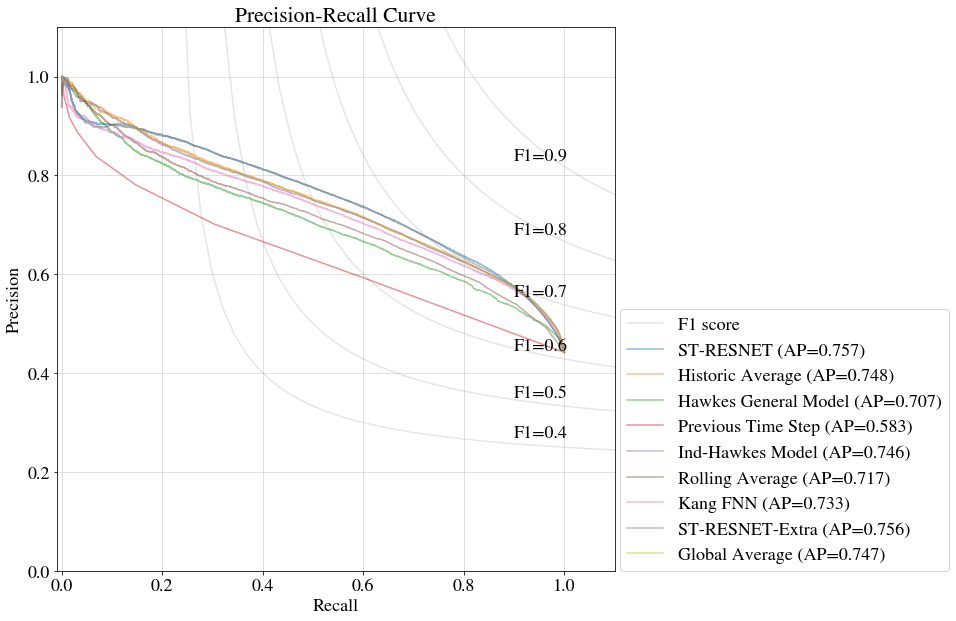

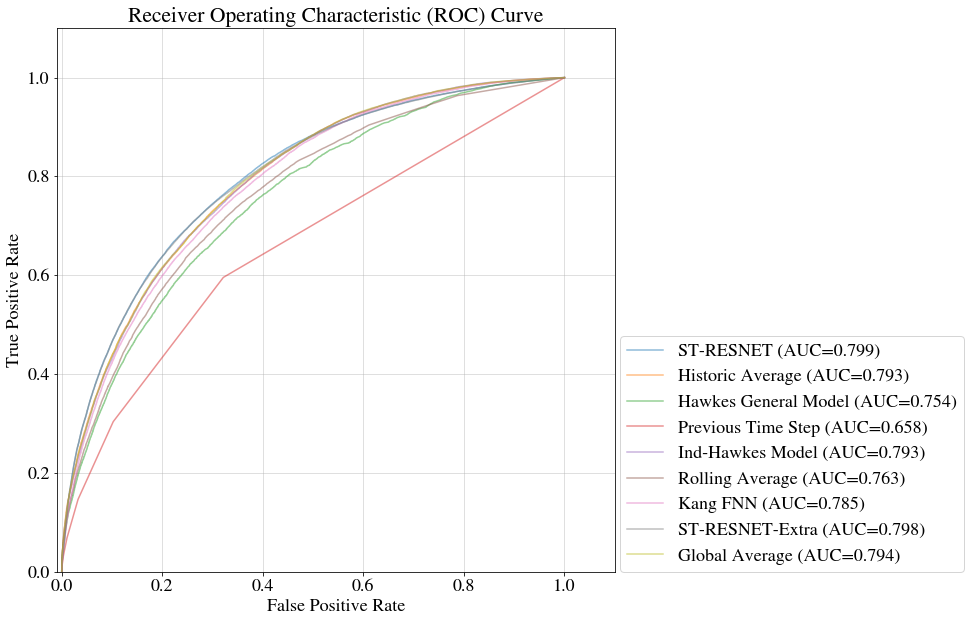

,Accuracy,ROC AUC,Avg. Precision,Recall,Precision,F1 Score,Matthews Corrcoef
Model Name,,,,,,,
Previous Time Step,0.441895,0.658416,0.583346,1.000000,0.441895,0.736852,0.000000
Hawkes General Model,0.660653,0.753543,0.707105,0.804511,0.584266,0.752670,0.357392
Rolling Average,0.663718,0.763296,0.717494,0.830361,0.584052,0.769812,0.372131
Historic Average,0.676171,0.792898,0.747870,0.870548,0.590636,0.804560,0.409349
Kang FNN,0.677304,0.785098,0.733179,0.852859,0.593924,0.788504,0.403392
Global Average,0.679828,0.793560,0.746980,0.860057,0.595336,0.799540,0.410530
Ind-Hawkes Model,0.684194,0.792523,0.745954,0.849653,0.600899,0.794434,0.413194
ST-RESNET,0.715742,0.798829,0.757424,0.766435,0.654445,0.761903,0.439237
ST-RESNET-Extra,0.719153,0.797580,0.756477,0.743848,0.665166,0.750109,0.440521


In [49]:
if USE_EXTRA:
    evaluate_fn = evaluate_st_res_net_extra
else:
    evaluate_fn = evaluate_st_res_net


trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                           batch_loader=loaders.train_loader,
                                                                           conf=conf) 
thresh = best_threshold(trn_y_true, trn_probas_pred) 

tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                           batch_loader=loaders.test_loader,
                                                           conf=conf)


tst_y_true = np.expand_dims(tst_y_true, axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


tst_y_pred = get_y_pred(thresh, tst_probas_pred)
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)
compare_models(data_path=conf.data_path)

2019-11-06T10:35:42 | root | INFO | 
========================= T3H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:42 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.820274  0.758481        0.246693  0.451091   0.228952   
Hawkes General Model  0.778712  0.692342        0.185714  0.419468   0.175860   
Previous Time Step    0.855931  0.546559        0.104627  0.171098   0.171104   
Ind-Hawkes Model      0.814989  0.737723        0.230659  0.427067   0.215363   
Rolling Average       0.785755  0.640628        0.153142  0.368326   0.167275   
Kang FNN              0.815829  0.740372        0.226428  0.432432   0.217952   
Global Average        0.780540  0.736865        0.211250  0.485662   0.194530   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
H

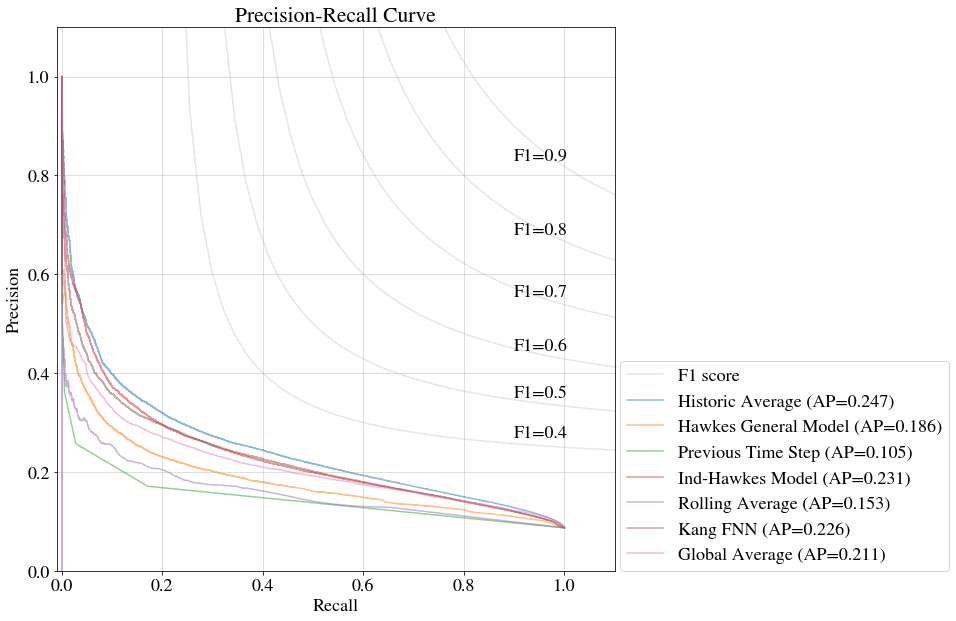

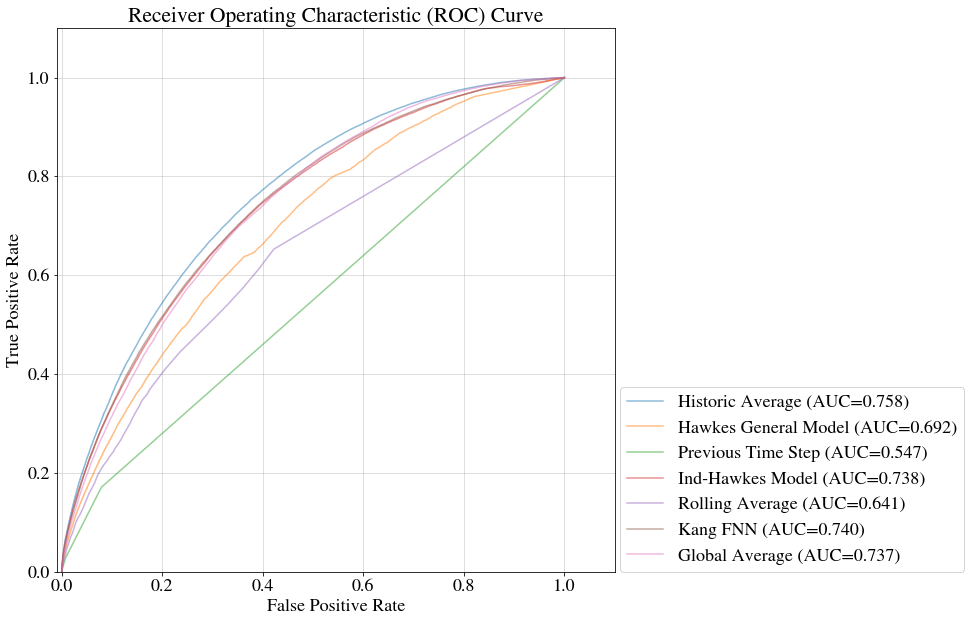

2019-11-06T10:35:44 | root | INFO | 
========================= T24H-X85M-Y110M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:44 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.924417  0.663488        0.098436  0.193815   0.132158   
Hawkes General Model  0.812485  0.556063        0.050842  0.273657   0.058164   
Previous Time Step    0.932782  0.521081        0.040603  0.076884   0.076685   
Ind-Hawkes Model      0.900410  0.674555        0.098903  0.254224   0.113106   
Rolling Average       0.929284  0.574735        0.060910  0.120593   0.101662   
Kang FNN              0.870258  0.610240        0.062066  0.210629   0.070449   
Global Average        0.911061  0.682550        0.100869  0.234961   0.122619   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
H

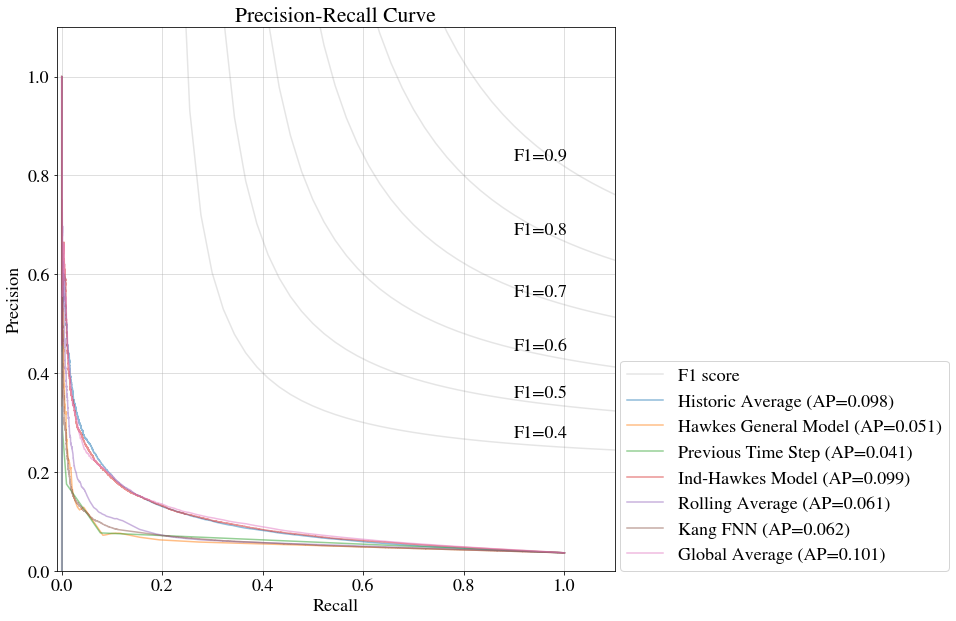

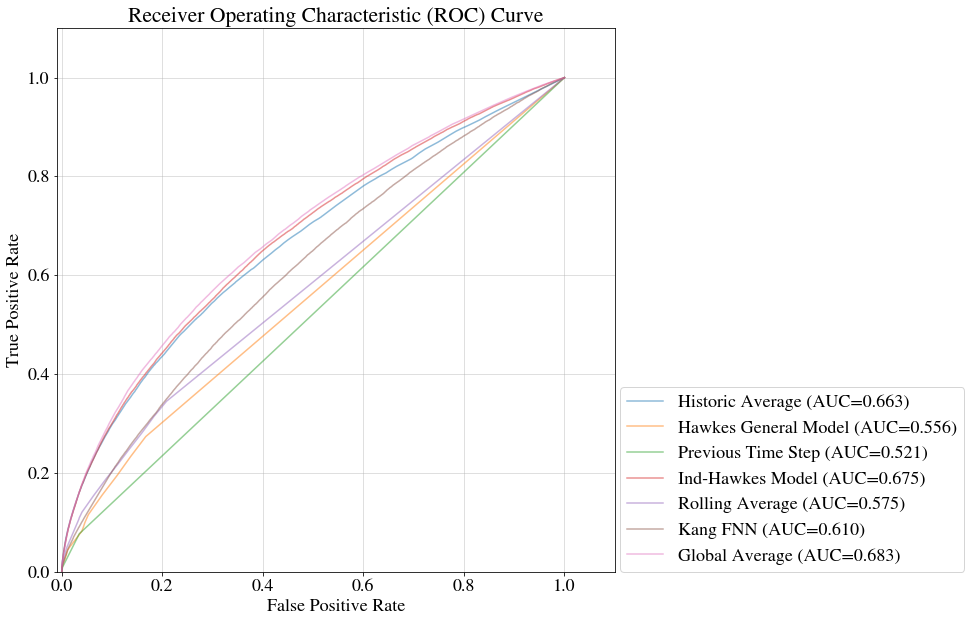

2019-11-06T10:35:44 | root | INFO | 
========================= T1H-X1700M-Y1760M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:45 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.789958  0.759761        0.269728  0.503793   0.246648   
Hawkes General Model  0.782932  0.732111        0.237502  0.457544   0.226717   
Previous Time Step    0.834246  0.552894        0.124947  0.197101   0.197083   
Ind-Hawkes Model      0.799798  0.747298        0.260383  0.457694   0.246733   
Rolling Average       0.764659  0.696985        0.202432  0.442033   0.204253   
Kang FNN              0.778104  0.759256        0.263123  0.526136   0.238926   
ST-RESNET-Extra       0.882969  0.806912        0.213972  0.447326   0.224621   
Global Average        0.750255  0.736238        0.227488  0.525948   0.212803   

                      

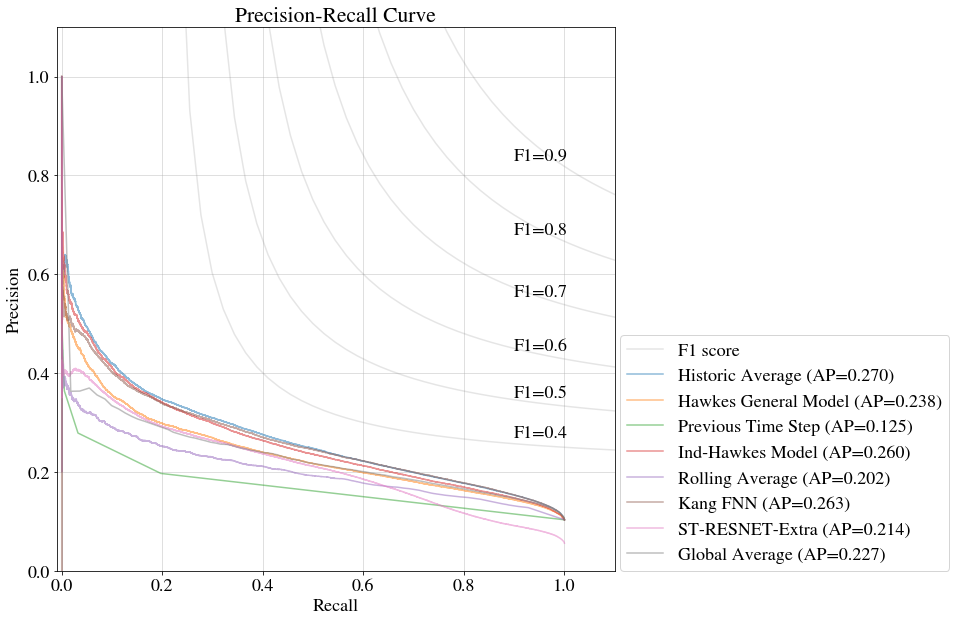

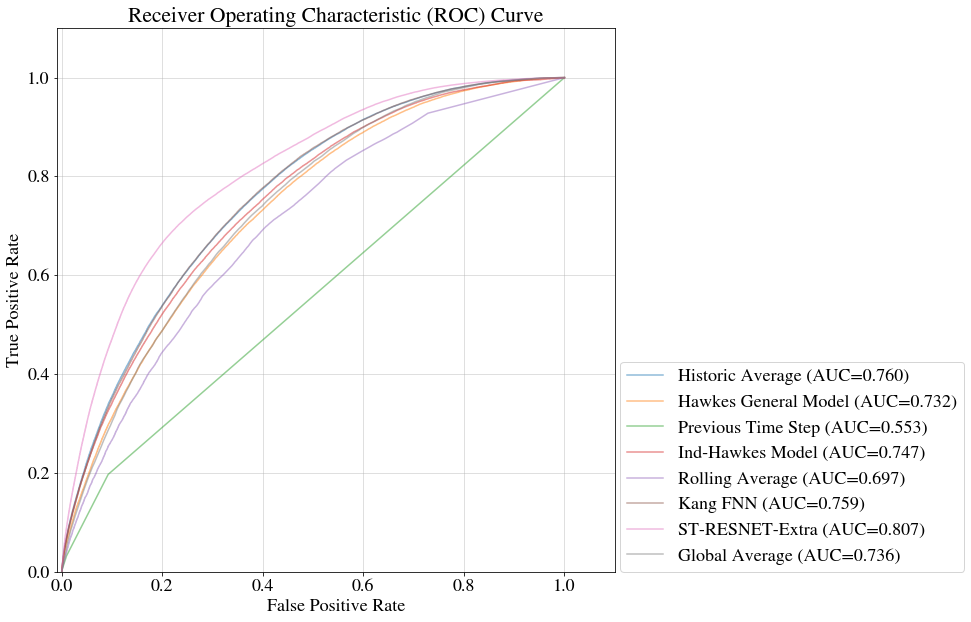

2019-11-06T10:35:46 | root | INFO | 
========================= T12H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:47 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.682669  0.774360        0.570916  0.739348   0.452295   
Hawkes General Model  0.669536  0.739148        0.526353  0.685485   0.435292   
Previous Time Step    0.274517  0.585015        0.336148  1.000000   0.274517   
Ind-Hawkes Model      0.668876  0.761730        0.543540  0.736686   0.438614   
Rolling Average       0.624004  0.643503        0.401297  0.620065   0.385183   
Kang FNN              0.689680  0.764332        0.551486  0.699703   0.457374   
Global Average        0.670260  0.760410        0.538680  0.730312   0.439474   

                      F1 Score  Matthews Corrcoef  
Model Name                                         


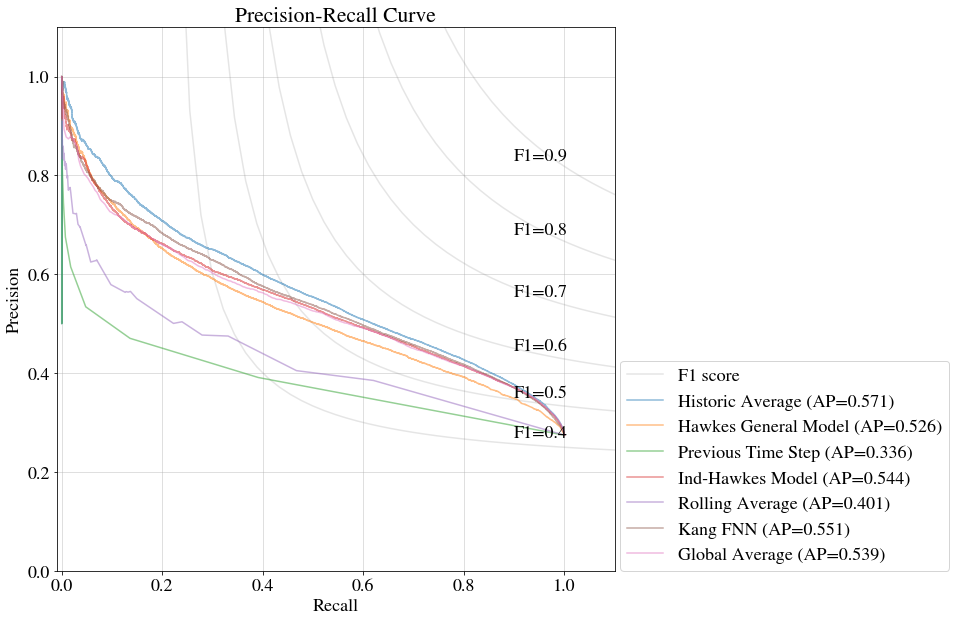

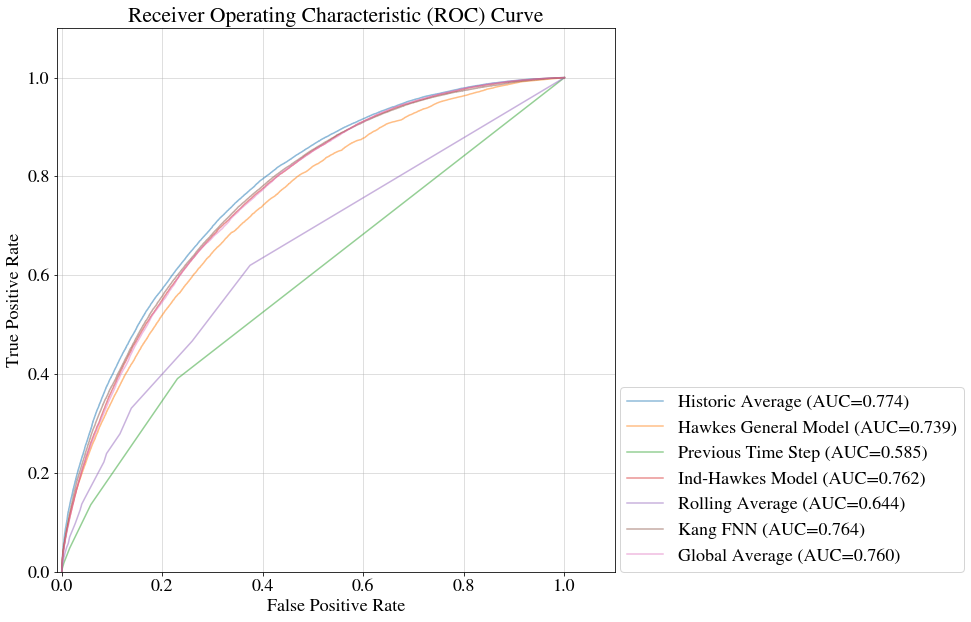

2019-11-06T10:35:48 | root | INFO | 
========================= T24H-X255M-Y220M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:48 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.828206  0.698118        0.202399  0.370205   0.201258   
Hawkes General Model  0.666999  0.628203        0.145236  0.502677   0.123384   
Previous Time Step    0.081844  0.537311        0.094977  1.000000   0.081844   
Ind-Hawkes Model      0.820722  0.703310        0.202164  0.386487   0.196840   
Rolling Average       0.821610  0.616622        0.145872  0.290435   0.164972   
Kang FNN              0.791219  0.653823        0.156585  0.361515   0.158978   
Global Average        0.816090  0.707595        0.204139  0.401311   0.195789   

                      F1 Score  Matthews Corrcoef  
Model Name                                         


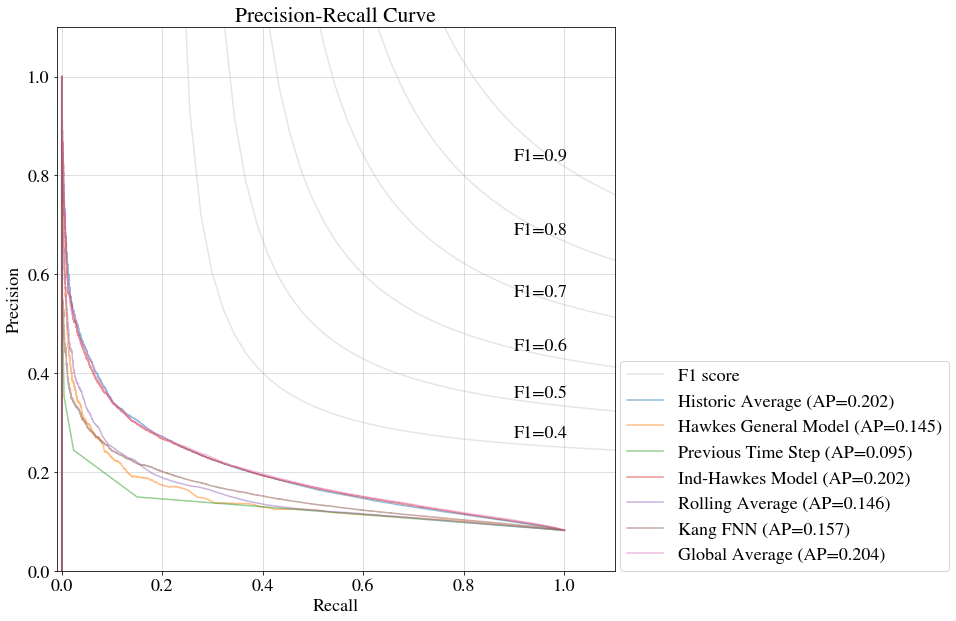

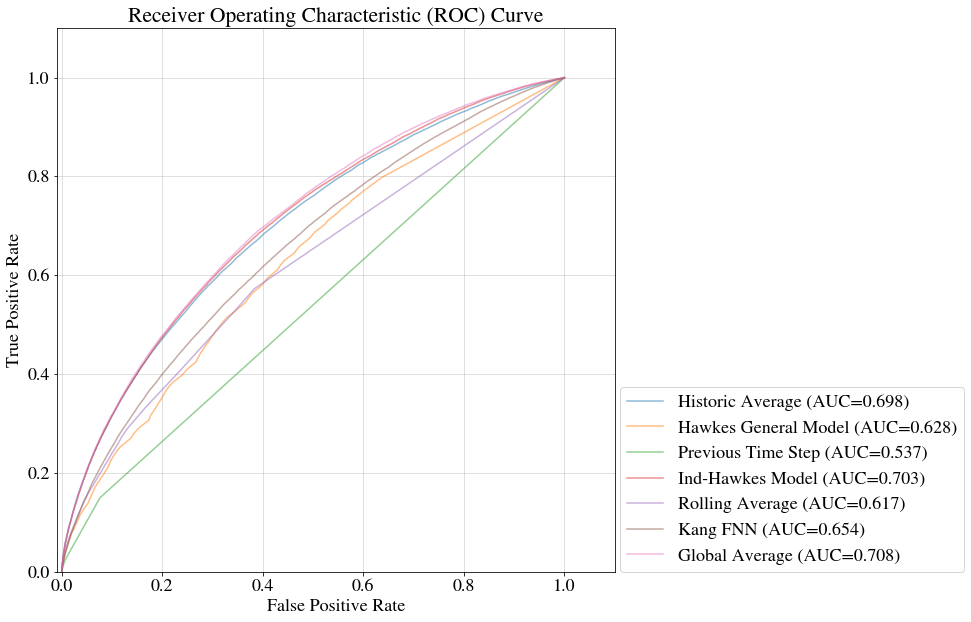

2019-11-06T10:35:48 | root | INFO | 
========================= T6H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:49 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.745582  0.762471        0.390244  0.588387   0.330487   
Hawkes General Model  0.710196  0.713110        0.327004  0.553583   0.286268   
Previous Time Step    0.158656  0.561398        0.191850  1.000000   0.158656   
Ind-Hawkes Model      0.736806  0.746597        0.364587  0.570050   0.316871   
Rolling Average       0.602439  0.640592        0.257738  0.639557   0.229650   
Kang FNN              0.752877  0.750872        0.367527  0.546867   0.331166   
Global Average        0.711711  0.744307        0.351575  0.612735   0.299986   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
H

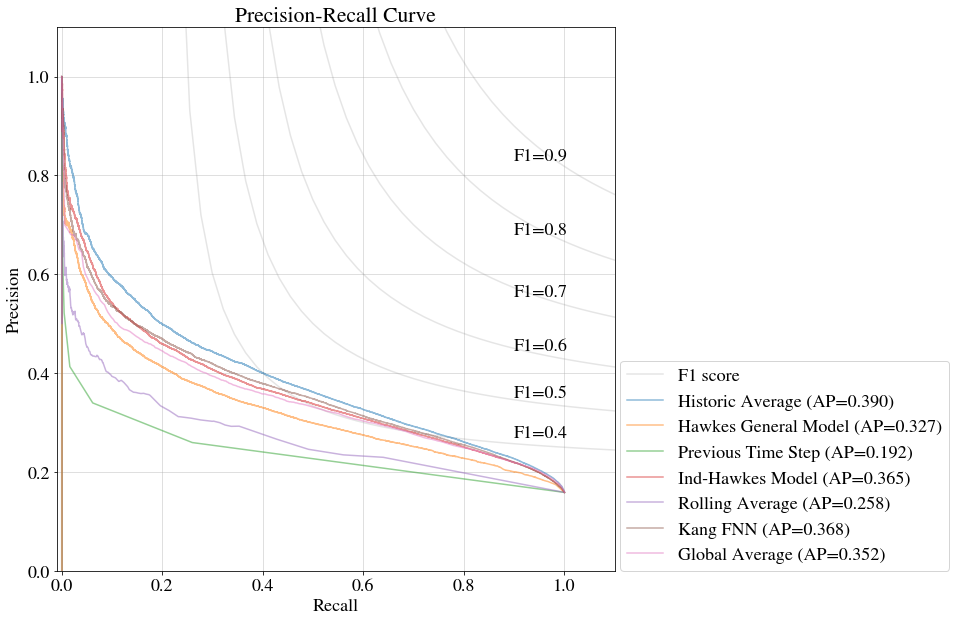

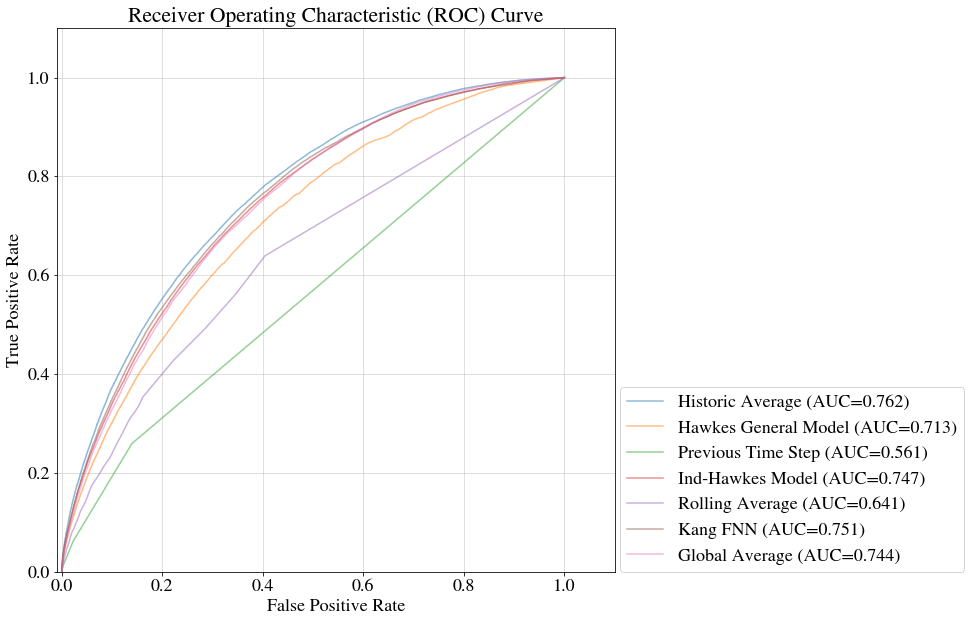

2019-11-06T10:35:49 | root | INFO | 
========================= T24H-X425M-Y440M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:49 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.707615  0.733282        0.402863  0.598265   0.334518   
Hawkes General Model  0.673189  0.679091        0.342597  0.557613   0.294321   
Previous Time Step    0.183669  0.571432        0.229976  1.000000   0.183669   
Ind-Hawkes Model      0.703780  0.735254        0.402596  0.607399   0.332350   
Rolling Average       0.665342  0.674439        0.342238  0.579580   0.292535   
Kang FNN              0.683097  0.695292        0.354485  0.567750   0.305094   
Global Average        0.704475  0.737138        0.403647  0.609698   0.333459   

                      F1 Score  Matthews Corrcoef  
Model Name                                         


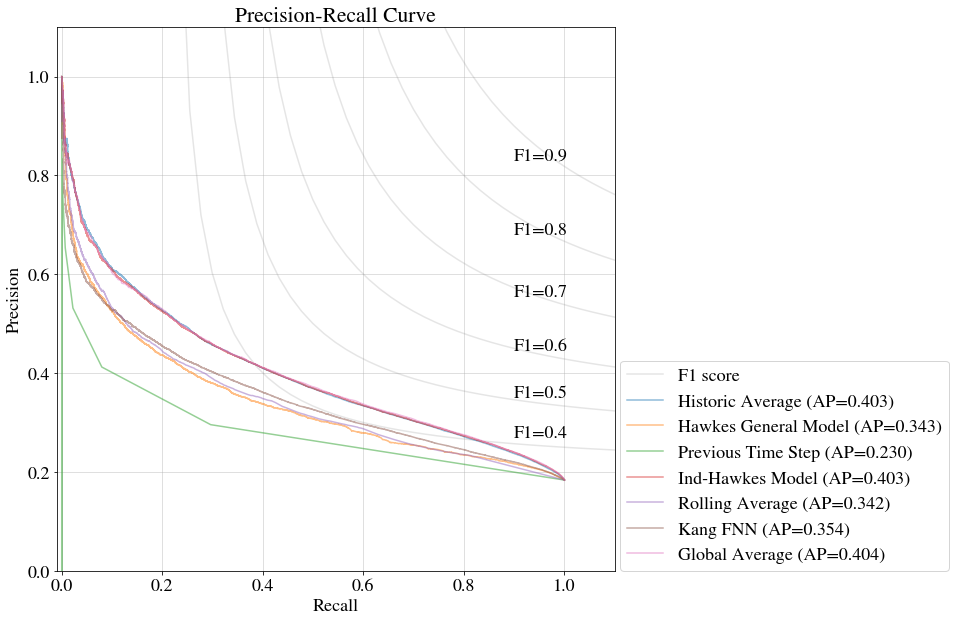

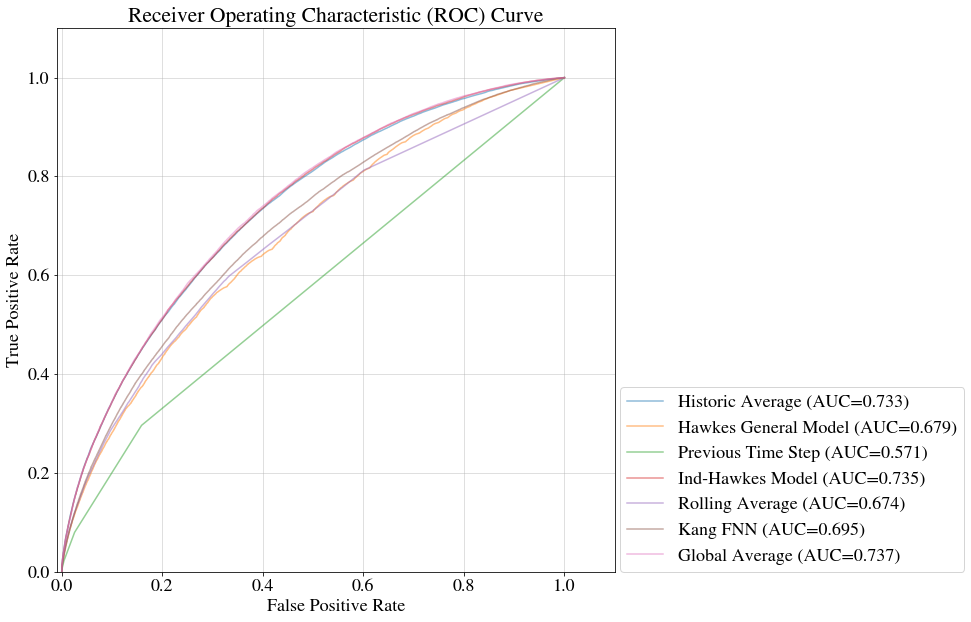

2019-11-06T10:35:50 | root | INFO | 
========================= T24H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:50 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
ST-RESNET             0.862626  0.918287        0.733665  0.775468   0.648686   
Historic Average      0.676171  0.792898        0.747870  0.870548   0.590636   
Hawkes General Model  0.660653  0.753543        0.707105  0.804511   0.584266   
Previous Time Step    0.441895  0.658416        0.583346  1.000000   0.441895   
Ind-Hawkes Model      0.684194  0.792523        0.745954  0.849653   0.600899   
Rolling Average       0.663718  0.763296        0.717494  0.830361   0.584052   
Kang FNN              0.677304  0.785098        0.733179  0.852859   0.593924   
ST-RESNET-Extra       0.865068  0.889745        0.711878  0.713206   0.673175   
Global Average        0.

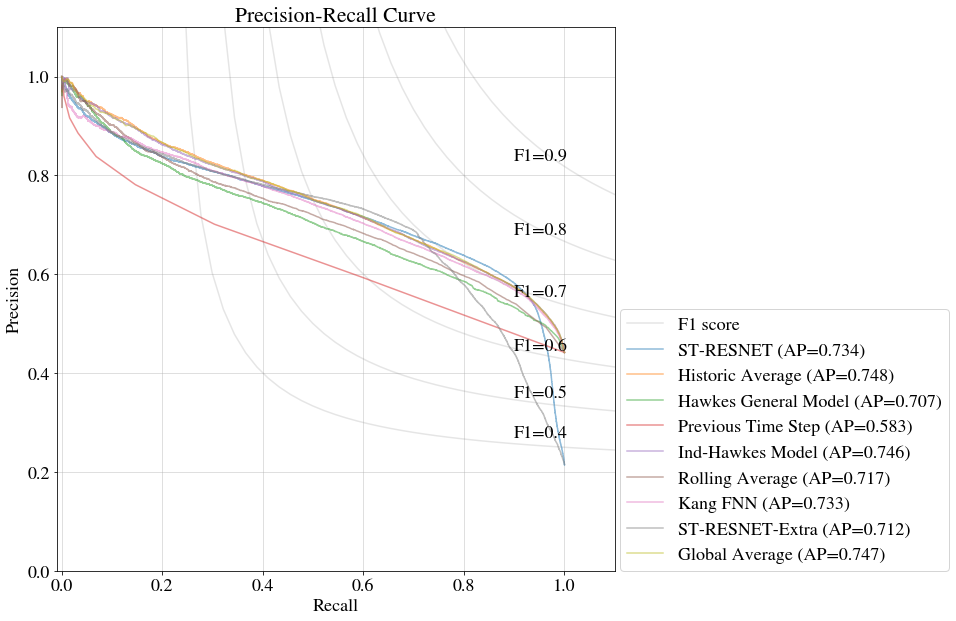

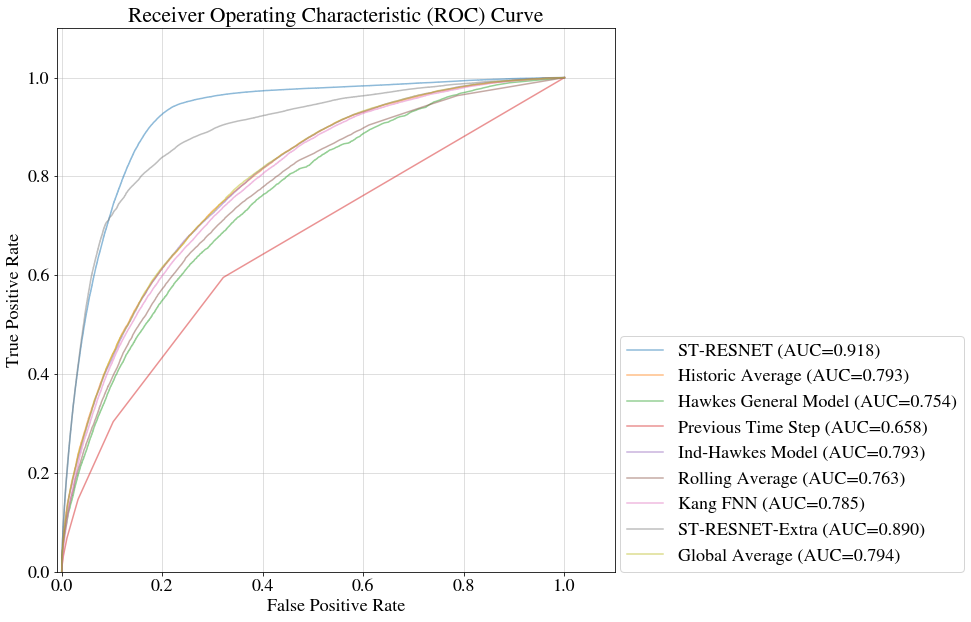

2019-11-06T10:35:51 | root | INFO | 
========================= T1H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-06T10:35:51 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.916126  0.752067        0.101365  0.255823   0.116079   
Hawkes General Model  0.880209  0.659421        0.062582  0.239519   0.072055   
Previous Time Step    0.942382  0.522844        0.034980  0.075329   0.075320   
Ind-Hawkes Model      0.918535  0.714674        0.090924  0.226480   0.109523   
Rolling Average       0.896826  0.642265        0.059926  0.214733   0.078335   
Kang FNN              0.908558  0.748096        0.094863  0.264612   0.107375   
Global Average        0.896895  0.732346        0.083297  0.273826   0.095838   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
H

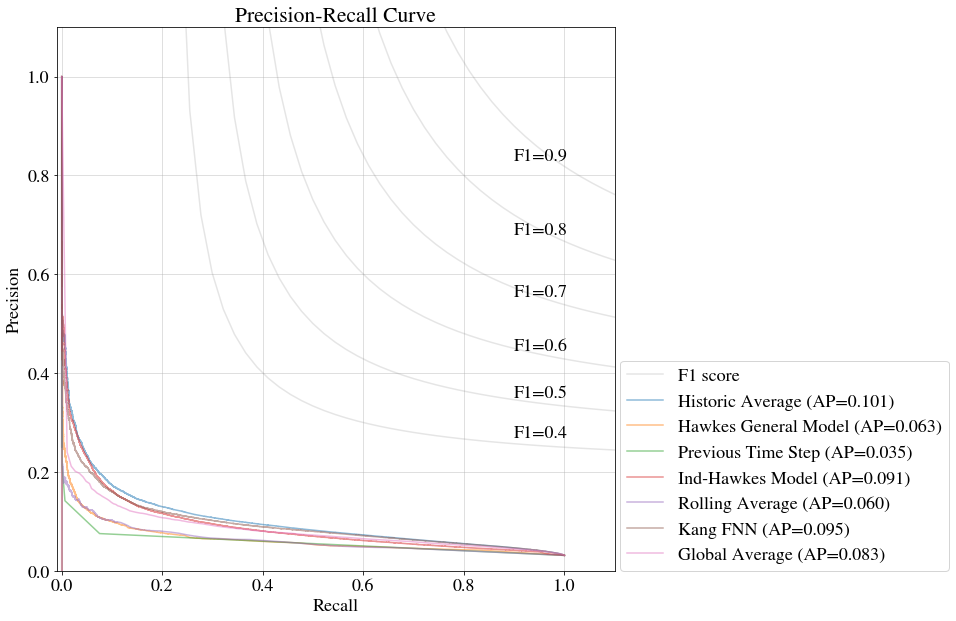

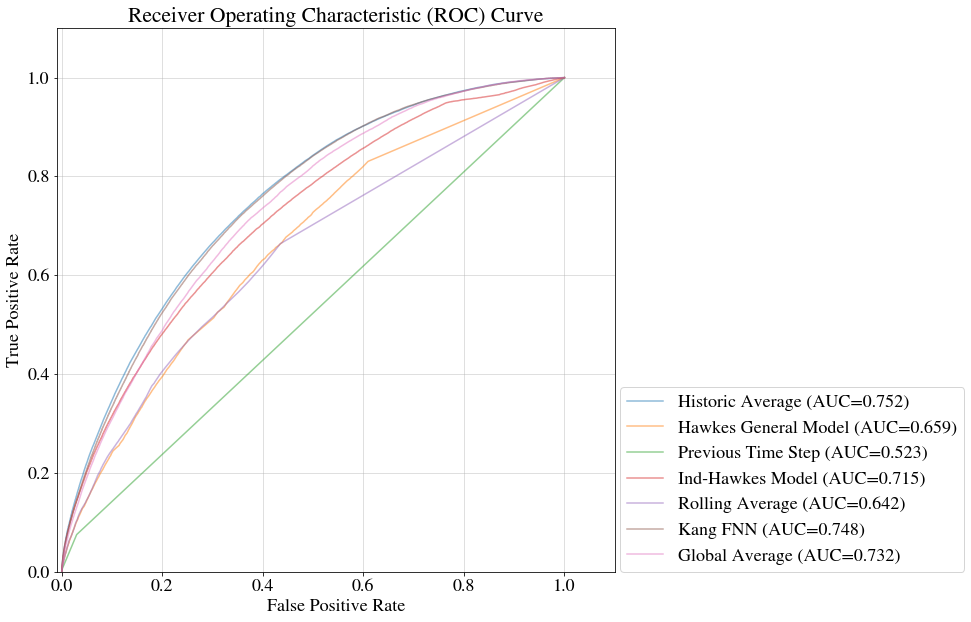

In [36]:
for data_sub_path in get_data_sub_paths():
    log.info(f"\n========================= {data_sub_path} =========================\n")
    conf = BaseConf()
    conf.data_path = f"./data/processed/{data_sub_path}/"
    compare_models(data_path=conf.data_path)

2019-11-06T13:25:46 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Previous Time Step    0.441895  0.658416        0.583346  1.000000   0.441895   
Hawkes General Model  0.660653  0.753543        0.707105  0.804511   0.584266   
Rolling Average       0.663718  0.763296        0.717494  0.830361   0.584052   
Historic Average      0.676171  0.792898        0.747870  0.870548   0.590636   
Kang FNN              0.677304  0.785098        0.733179  0.852859   0.593924   
Global Average        0.679828  0.793560        0.746980  0.860057   0.595336   
Ind-Hawkes Model      0.684194  0.792523        0.745954  0.849653   0.600899   
ST-RESNET             0.715742  0.798829        0.757424  0.766435   0.654445   
ST-RESNET-Extra       0.719153  0.797580        0.756477  0.743848   0.665166   

                      F1 Score  Matthews Corrcoef  
Model Name         

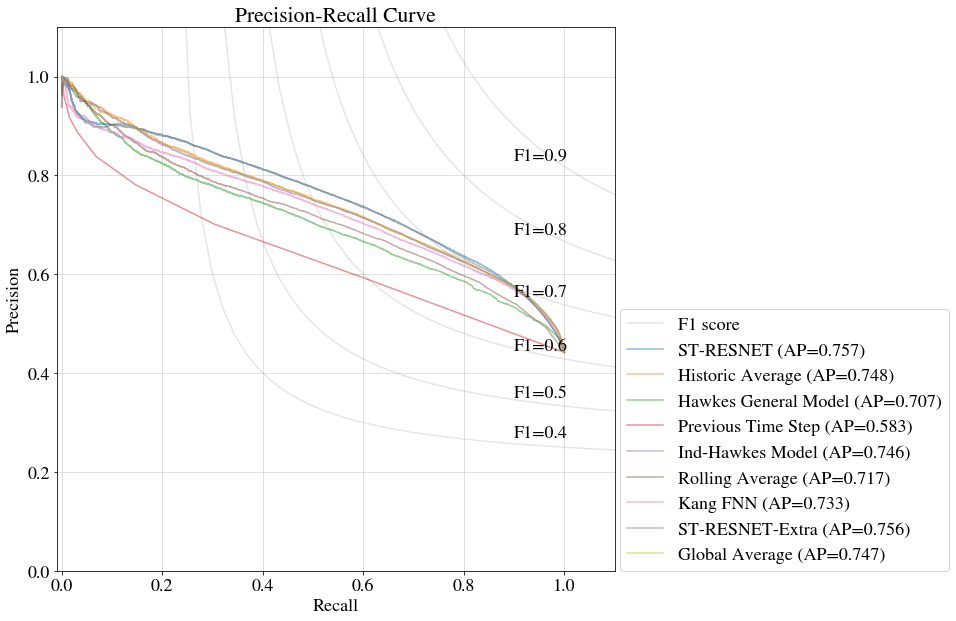

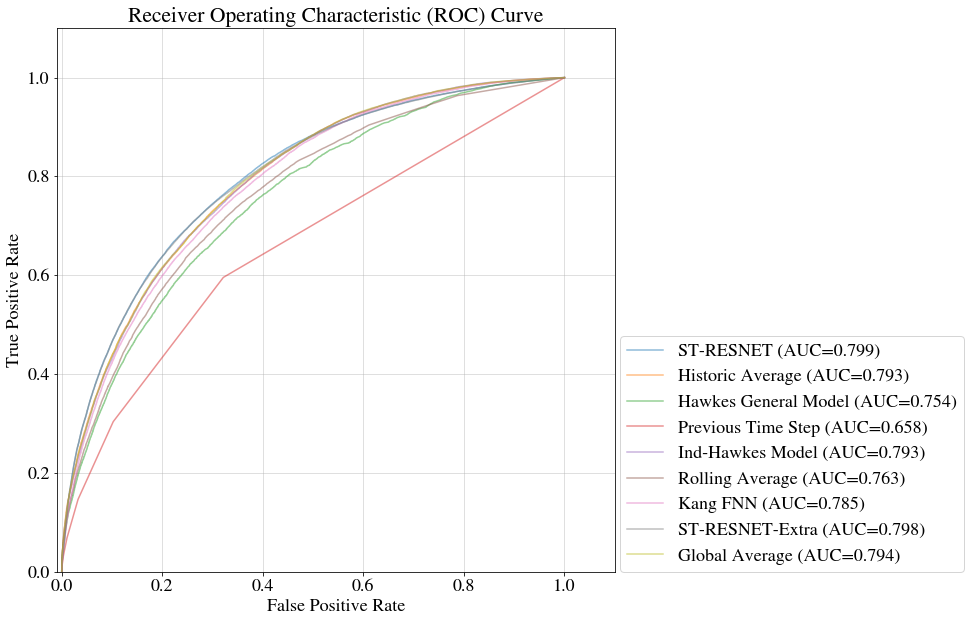

In [56]:
df = compare_models(data_path=conf.data_path)

## All in one

In [36]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf

from utils.utils import write_json, Timer, get_data_sub_paths
from models.st_resnet_models import STResNet, STResNetExtra
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_fnn_data_classification
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape
from models.model_result import save_metrics, compare_models

In [37]:
data_sub_paths = os.listdir("./data/processed/")
data_sub_paths

['.DS_Store',
 'T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [40]:
for data_sub_path in get_data_sub_paths():
    log.info(f"Working on data {data_sub_path}")
    
    conf = BaseConf()
    USE_EXTRA = True # todo move extra model to own notebook
    if USE_EXTRA:
        conf.model_name = "ST-RESNET-Extra"  # needs to be created
    else:     
        conf.model_name = "ST-RESNET"  # needs to be created

    conf.data_path = f"./data/processed/{data_sub_path}/"

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.data_path, exist_ok=True)
    os.makedirs(conf.model_path, exist_ok=True)

    # logging config is set globally thus we only need to call this in this file
    # imported function logs will follow the configuration
    setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
    log.info(f"\n===================={conf.data_path}====================")

    info = deepcopy(conf.__dict__)
    info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.cuda.manual_seed( conf.seed)
    else:
        torch.manual_seed(conf.seed)

    device = torch.device("cuda:0" if use_cuda else "cpu")
    log.info(f"Device: {device}")
    info["device"] = device.type
    conf.device = device

 

    # SET THE HYPER PARAMETERS
    conf.early_stopping = False
    conf.max_epochs = 15
    conf.dropout = 0.2
    conf.weight_decay = 0
    conf.checkpoint = "best" # ["best"|"latest"]
    conf.lr = 1e-2
    conf.batch_size = 256

    # MOCK = False

    # CRIME DATA
    data_group = GridDataGroup(data_path=conf.data_path,
                            conf=conf)

    loaders = GridDataLoaders(data_group=data_group,
                            conf=conf)

2019-11-06T11:50:28 | root | INFO | Working on data T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-06T11:50:28 | root | INFO | 
====================./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/====================
2019-11-06T11:50:28 | root | INFO | Device: cpu
2019-11-06T11:50:28 | root | INFO | 	t_range shape (5841,)
2019-11-06T11:50:29 | root | INFO | Working on data T24H-X85M-Y110M_2013-01-01_2015-01-01
2019-11-06T11:50:29 | root | INFO | 
====================./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/====================
2019-11-06T11:50:29 | root | INFO | Device: cpu
2019-11-06T11:50:31 | root | INFO | 	t_range shape (731,)


ValueError: self.scale_old is [[[1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [3.        ]
  [2.        ]
  [2.32192809]
  [2.80735492]
  [2.        ]
  [2.        ]
  [2.5849625 ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.80735492]
  [1.5849625 ]
  [2.32192809]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.80735492]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.5849625 ]
  [2.        ]
  [2.80735492]
  [2.        ]
  [3.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.5849625 ]
  [2.32192809]
  [2.32192809]
  [3.32192809]
  [2.        ]
  [2.5849625 ]
  [2.32192809]
  [2.5849625 ]
  [3.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.32192809]
  [2.80735492]
  [2.        ]
  [2.        ]
  [2.32192809]
  [3.        ]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.32192809]
  [2.80735492]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.80735492]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.5849625 ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [2.        ]
  [2.5849625 ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.5849625 ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.32192809]
  [2.32192809]
  [2.        ]
  [2.5849625 ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.5849625 ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [2.32192809]
  [2.        ]
  [2.        ]
  [2.32192809]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [1.        ]
  [1.        ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [2.        ]
  [1.5849625 ]
  [1.5849625 ]
  [2.        ]
  [1.5849625 ]
  [1.        ]
  [1.5849625 ]
  [1.        ]
  [1.        ]
  [1.5849625 ]
  [1.        ]
  [1.        ]
  [0.        ]]]. Cannot device by zero. Data shape -> (729, 376, 323)

In [17]:
# start_date = "2013-01-01"
# end_date = "2015-01-01" 

# data_dim_str = "T1H-X1700M-Y1760M" # "T24H-X850M-Y880M" # needs to exist

for data_sub_path in get_data_sub_paths():
    log.info(f"Working on data {data_sub_path}")
    
    conf = BaseConf()
    USE_EXTRA = True # todo move extra model to own notebook
    if USE_EXTRA:
        conf.model_name = "ST-RESNET-Extra"  # needs to be created
    else:     
        conf.model_name = "ST-RESNET"  # needs to be created

    conf.data_path = f"./data/processed/{data_sub_path}/"

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.data_path, exist_ok=True)
    os.makedirs(conf.model_path, exist_ok=True)

    # logging config is set globally thus we only need to call this in this file
    # imported function logs will follow the configuration
    setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    info = deepcopy(conf.__dict__)
    info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.cuda.manual_seed( conf.seed)
    else:
        torch.manual_seed(conf.seed)

    device = torch.device("cuda:0" if use_cuda else "cpu")
    log.info(f"Device: {device}")
    info["device"] = device.type
    conf.device = device

    # fix normal one first then add the extras
    def train_epoch_for_st_res_net_extra(model, optimiser, batch_loader, loss_fn, total_losses, conf):
        """
        Training the STResNetExtra model for a single epoch
        """
        epoch_losses = []
        num_batches = batch_loader.num_batches
        
        demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
        street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)

        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch

            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_pred = model(seq_c=batch_seq_c,
                            seq_p=batch_seq_p,
                            seq_q=batch_seq_q,
                            seq_e=batch_seq_e,
                            seq_demog=demog_grid,
                            seq_gsv=street_grid)
            
            # might need to flatten
            loss = loss_fn(input=batch_pred, target=batch_seq_t)
            epoch_losses.append(loss.item())
            total_losses.append(epoch_losses[-1])
            
            if model.training:
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
        mean_epoch_loss = np.mean(epoch_losses)
        
        return mean_epoch_loss


    def train_epoch_for_st_res_net(model, optimiser, batch_loader, loss_fn, total_losses, conf):
        """
        Training the STResNet model for a single epoch
        """
        c = 0
        epoch_losses = []
        num_batches = batch_loader.num_batches
        
        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch

            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_pred = model(seq_c=batch_seq_c,
                            seq_p=batch_seq_p,
                            seq_q=batch_seq_q,
                            seq_e=batch_seq_e)
            
            # might need to flatten
            loss = loss_fn(input=batch_pred, target=batch_seq_t)
            epoch_losses.append(loss.item())
            total_losses.append(epoch_losses[-1])
            
            if model.training:
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
            c += 1
            if c > 100:
                break
        mean_epoch_loss = np.mean(epoch_losses)
        
        return mean_epoch_loss

    # SET THE HYPER PARAMETERS
    conf.early_stopping = False
    conf.max_epochs = 15
    conf.dropout = 0.2
    conf.weight_decay = 0
    conf.checkpoint = "best" # ["best"|"latest"]
    conf.lr = 1e-2
    conf.batch_size = 256

    # MOCK = False

    # CRIME DATA
    data_group = GridDataGroup(data_path=conf.data_path,
                            conf=conf)

    loaders = GridDataLoaders(data_group=data_group,
                            conf=conf)

    conf.resume = False
    conf.freqstr = data_group.t_range.freqstr    

    # SET LOSS FUNCTION
    # size averaged - so more epochs or larger lr for smaller batches
    loss_function = nn.MSELoss()  

    # SETUP MODEL
    dataset = loaders.train_loader.dataset
    _, h_size, w_size = dataset.crimes.shape
    _, n_ext_features = dataset.time_vectors.shape

    if USE_EXTRA:
        train_epoch_fn = train_epoch_for_st_res_net
        model = STResNetExtra(n_layers=3,
                            n_channels=1,
                            y_size=h_size,
                            x_size=w_size,

                            lc=dataset.n_steps_c,
                            lp=dataset.n_steps_p,
                            lq=dataset.n_steps_q,

                            n_ext_features=n_ext_features,
                            n_demog_features=37,
                            n_demog_channels=10,
                            n_demog_layers=3,

                            n_gsv_features=512,
                            n_gsv_channels=10,
                            n_gsv_layers=3)
    else:
        train_epoch_fn = train_epoch_for_st_res_net
        model = STResNet(n_layers=3,
                        n_channels=1,
                        y_size=h_size,
                        x_size=w_size,

                        lc=dataset.n_steps_c,
                        lp=dataset.n_steps_p,
                        lq=dataset.n_steps_q,

                        n_ext_features=n_ext_features)    
        
    # todo implement model_arch for res-net
    model.to(conf.device)

    # SETUP OPTIMISER
    parameters = model.parameters()
    # todo (optional): setup model parameters dynamically 

    optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

    if conf.resume:
        try:
            # resume from previous check point or resume from best validaton score checkpoint
            # load model state
            model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
            model.load_state_dict(model_state_dict)
            
            # load optimiser state
            optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
            optimiser.load_state_dict(optimiser_state_dict) 

    #         # new optimiser hyper-parameters
    #         optimiser.param_groups[0]['lr'] = conf.lr
    #         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        except Exception as e:
            log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                            optimiser=optimiser,
                                            loaders=loaders,
                                            train_epoch_fn=train_epoch_fn,
                                            loss_fn=loss_function,
                                            conf=conf)    

    print(f"stopped_early: {stopped_early}") # use the current epoch instead
    # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

    from utils.metrics import best_threshold

    # FIX NORMAL ONE FIRST THEN ADD THE EXTRAS
    def evaluate_st_res_net_extra(model, batch_loader, conf):  
        """
        Only used to get probas in a time and location based format. The hard predictions should be done outside 
        this function where the threshold is determined using only the training data
        """
        
        probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
        y_counts = batch_loader.dataset.targets[-len(probas_pred):]
        y_true = np.copy(y_counts)
        y_true[y_true > 0] = 1

        
        t_range = batch_loader.dataset.t_range[-len(probas_pred):]
        
        with torch.set_grad_enabled(False):
            model.eval()
                
            num_batches = batch_loader.num_batches
            
            demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
            street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
            
            for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
                current_batch = batch_loader.current_batch
                
                batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
                batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
                batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
                batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
                batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

                batch_probas_pred = model(seq_c=batch_seq_c,
                                        seq_p=batch_seq_p,
                                        seq_q=batch_seq_q,
                                        seq_e=batch_seq_e,
                                        seq_demog=demog_grid,
                                        seq_gsv=street_grid)
                    
                for i,p in zip(batch_indices, batch_probas_pred.cpu().numpy()):
                    probas_pred[i] = p
                    
        
        return y_counts, y_true, probas_pred, t_range

    def evaluate_st_res_net(model, batch_loader, conf):    
        """
        Only used to get probas in a time and location based format. The hard predictions should be done outside 
        this function where the threshold is determined using only the training data
        """
        
        probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
        y_counts = batch_loader.dataset.targets[-len(probas_pred):]
        y_true = np.copy(y_counts)
        y_true[y_true > 0] = 1
        
        
        t_range = batch_loader.dataset.t_range[-len(probas_pred):]
        
        with torch.set_grad_enabled(False):
            model.eval()
                
            num_batches = batch_loader.num_batches
            
            demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
            street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
            
            for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
                current_batch = batch_loader.current_batch

                batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
                batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
                batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
                batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
                batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

                batch_probas_pred = model(seq_c=batch_seq_c,
                                        seq_p=batch_seq_p,
                                        seq_q=batch_seq_q,
                                        seq_e=batch_seq_e)                
                    
                for i,p in zip(batch_indices, batch_probas_pred.cpu().numpy()):
                    probas_pred[i] = p           

        
        return y_counts, y_true, probas_pred, t_range

    from utils.metrics import best_threshold
    from utils.metrics import PRCurvePlotter, ROCCurvePlotter, PerTimeStepPlotter

    if USE_EXTRA:
        evaluate_fn = evaluate_st_res_net_extra
    else:
        evaluate_fn = evaluate_st_res_net


    trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                            batch_loader=loaders.train_loader,
                                                                            conf=conf) 
    thresh = best_threshold(trn_y_true, trn_probas_pred) 

    tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                            batch_loader=loaders.test_loader,
                                                            conf=conf)


    tst_y_pred = get_y_pred(thresh, tst_probas_pred)
    save_metrics(y_true=tst_y_true,
                y_pred=tst_y_pred,
                probas_pred=tst_probas_pred,
                t_range=tst_t_range,
                shaper=data_group.shaper,                
                conf=conf)
    compare_models(data_path=conf.data_path)

2019-11-06T10:21:40 | root | INFO | Working on data .DS_Store


Exception: Directory (./data/processed/.DS_Store/) needs to exist.

probas_pred


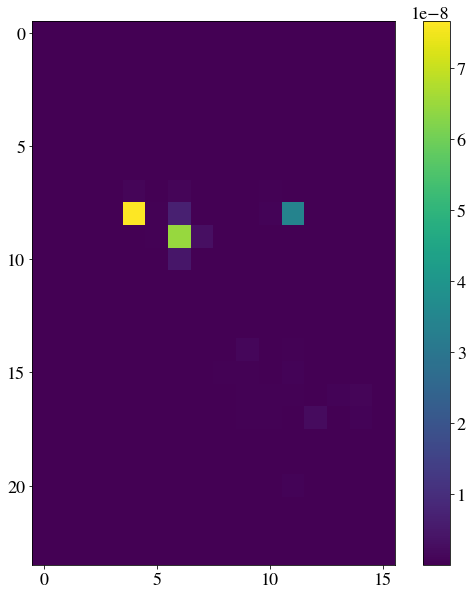

y_true


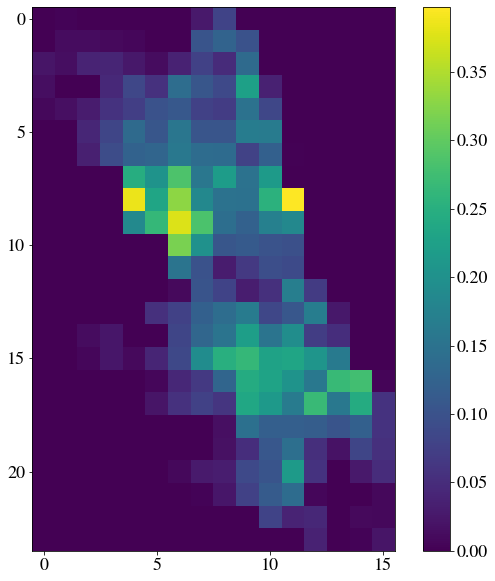

y_pred


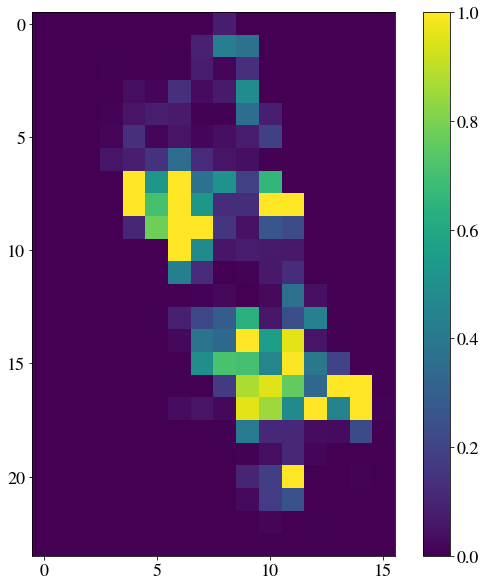

y_counts


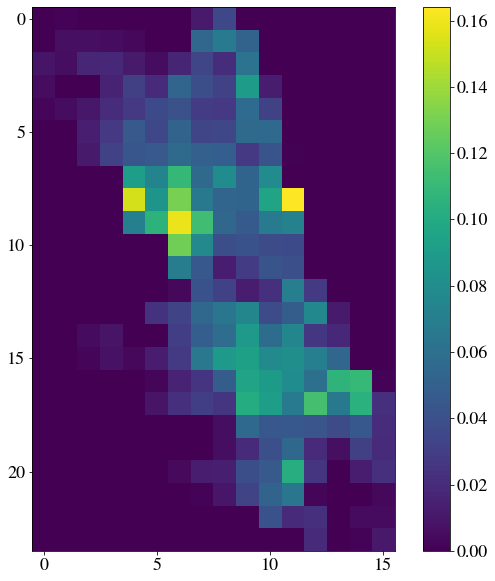

NameError: ignored

In [0]:
print("probas_pred")
im(tst_probas_pred.mean(0))
print("y_true")
im(tst_y_true.mean(0))
print("y_pred")
im(tst_y_pred.mean(0))
print("y_counts")
im(tst_y_counts.mean(0))

y_counts=data_group.shaper.squeeze(np.expand_dims(y_counts,axis=1))    
y_true=data_group.shaper.squeeze(np.expand_dims(y_true,axis=1))
y_pred=data_group.shaper.squeeze(np.expand_dims(y_pred,axis=1))
probas_pred=data_group.shaper.squeeze(np.expand_dims(probas_pred,axis=1))